# Dataset preprocessing

In this notebook, three preprocessing functions are applied to retinal fundus images. 

1. Ben's preprocessing: preprocessing method which is used by the winner during diabetic retinopathy competition held by Kaggle in 2015. This method is also commonly used in some studies.
2. Nakhon's preprocessing: most voted preprocessing notebook in Aptos Diabetic Retinopathy Competition. Similar to Ben's preprocessing but he masking the image with circular crop.
3. Enhanced green channel: several studies mention that green channel contains most information.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import needed library
import os
import fnmatch
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("dark_background")

In [3]:
!dir "D:/Datasets/thesis_dr/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr

12/11/2020  12:35 AM    <DIR>          .
12/11/2020  12:35 AM    <DIR>          ..
10/29/2020  01:01 AM    <DIR>          all_images
11/23/2020  01:59 PM    <DIR>          all_images_2
11/22/2020  07:54 PM    <DIR>          all_images_rescaled
10/29/2020  08:37 AM         2,327,471 all_image_label - Copy.csv
10/29/2020  08:37 AM         2,327,471 all_image_label.csv
12/06/2020  07:47 AM    <DIR>          aptos2019-blindness-detection
12/18/2019  03:27 AM            54,948 aptos_train.csv
10/29/2020  06:32 AM    <DIR>          balance_set
10/31/2020  10:45 AM    <DIR>          balance_set_enhanced_green
10/31/2020  01:24 AM    <DIR>          balance_set_graham
11/07/2020  07:00 AM           214,111 balance_set_label.csv
10/31/2020  08:28 AM    <DIR>          balance_set_nakhon
10/29/2020  11:14 AM    <DIR>          balance_set_rescaled
11/26/2020  12:37 AM         4,042,617 df_ex

In [4]:
dir_base = "D:/Datasets/thesis_dr/aptos2019-blindness-detection/"
dir_src = os.path.join(dir_base, "train_images")
dir_dst_rescaled = os.path.join(dir_base, "train_images_rescaled_300")
dir_dst_crop = os.path.join(dir_base, "train_images_rescaled_300_crop")
dir_dst_btgraham = os.path.join(dir_base, "train_images_rescaled_300_btgraham")
dir_dst_nakhon = os.path.join(dir_base, "train_images_rescaled_300_nakhon")
dir_dst_enhanced_green = os.path.join(
    dir_base, "train_images_rescaled_300_enhanced_green")
dir_dst_enhanced_green_crop_nakhon = os.path.join(
    dir_base, "train_images_rescaled_300_enhanced_green_crop_nakhon")

In [5]:
if os.path.isdir(dir_dst_rescaled) == False:
    os.mkdir(dir_dst_rescaled)

In [6]:
if os.path.isdir(dir_dst_crop) == False:
    os.mkdir(dir_dst_crop)

In [7]:
if os.path.isdir(dir_dst_btgraham) == False:
    os.mkdir(dir_dst_btgraham)

In [8]:
if os.path.isdir(dir_dst_nakhon) == False:
    os.mkdir(dir_dst_nakhon)

In [9]:
if os.path.isdir(dir_dst_enhanced_green) == False:
    os.mkdir(dir_dst_enhanced_green)

In [10]:
if os.path.isdir(dir_dst_enhanced_green_crop_nakhon) == False:
    os.mkdir(dir_dst_enhanced_green_crop_nakhon)

In [11]:
fnames = fnmatch.filter(os.listdir(dir_src), "*.png")
len(fnames)

3662

# BTGraham Preprocessing

- https://github.com/btgraham/SparseConvNet/blob/kaggle_Diabetic_Retinopathy_competition/Data/kaggleDiabeticRetinopathy/preprocessImages.py
-https://github.com/tensorflow/datasets/blob/4385c86379a9dc3bb6e9cfa629eadfe32de43082/tensorflow_datasets/image_classification/diabetic_retinopathy_detection.py#L261

In [12]:
def _scale_radius_size(image, target_radius_size=300):
    """Scale the input image so that the radius of the eyeball is the given."""
    x = image[image.shape[0] // 2, :, :].sum(axis=1)
    r = (x > x.mean() / 10.0).sum() / 2.0
    if r < 1.0:
        # Some images in the dataset are corrupted, causing the radius heuristic to
        # fail. In these cases, just assume that the radius is the height of the
        # original image.
        r = image.shape[0] / 2.0
    s = target_radius_size / r
    return cv2.resize(image, dsize=None, fx=s, fy=s)

In [13]:
def _subtract_local_average(image, target_radius_size=300):
    image_blurred = cv2.GaussianBlur(image, (0, 0), target_radius_size / 30)
    image = cv2.addWeighted(image, 4, image_blurred, -4, 128)
    return image

In [14]:
def _mask_and_crop_to_radius(image, target_radius_size=300, radius_mask_ratio=0.9, crop_to_radius=False):
    """Mask and crop image to the given radius ratio."""
    mask = np.zeros(image.shape)
    center = (image.shape[1]//2, image.shape[0]//2)
    radius = int(target_radius_size * radius_mask_ratio)
    cv2.circle(mask, center=center, radius=radius,
               color=(1, 1, 1), thickness=-1)
    image = image * mask + (1 - mask) * 128
    if crop_to_radius:
        x_max = min(image.shape[1] // 2 + radius, image.shape[1])
        x_min = max(image.shape[1] // 2 - radius, 0)
        y_max = min(image.shape[0] // 2 + radius, image.shape[0])
        y_min = max(image.shape[0] // 2 - radius, 0)
        image = image[y_min:y_max, x_min:x_max, :]
    return image

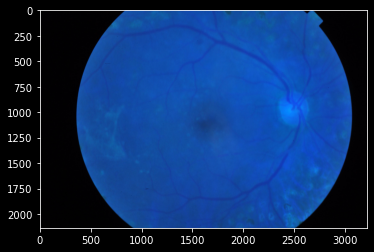

In [15]:
img = cv2.imread(os.path.join(dir_src, fnames[1]))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

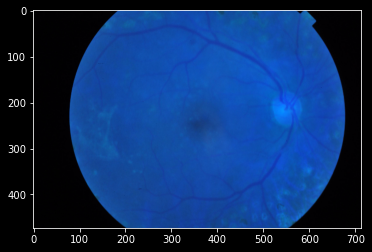

In [16]:
img = _scale_radius_size(img, 300)
plt.imshow(img)

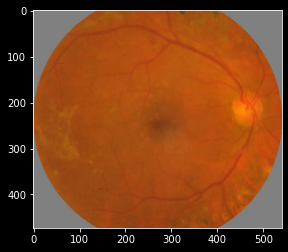

In [17]:
img1 = _mask_and_crop_to_radius(img, 300, 0.9, True)
cv2.imwrite("tes.jpeg", img1, [int(cv2.IMWRITE_JPEG_QUALITY), 72])
img1 = cv2.imread("tes.jpeg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)

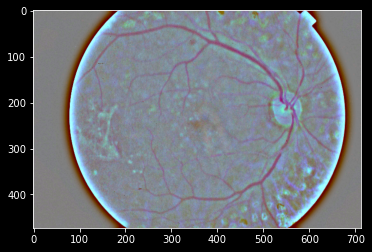

In [18]:
img = _subtract_local_average(img, 300)
plt.imshow(img)

In [19]:
img = _mask_and_crop_to_radius(img, 300, 0.9, True)
cv2.imwrite("tes.jpeg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 72])

True

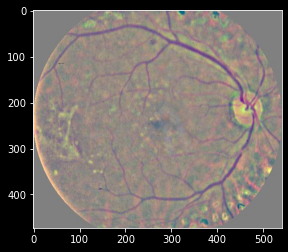

In [20]:
img = cv2.imread("tes.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Nakhon Preprocessing

https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

Modification:
- Using cv2 default color formation, BGR

In [21]:
# cropping black border
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            # print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1, img2, img3], axis=-1)
            # print(img.shape)
        return img

In [22]:
def circle_crop(img, sigmaX=10):
    """
    Create circular crop around image centre    
    """
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    # create circle masking
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)

    img = crop_image_from_gray(img)

    # apply gaussian blur
    img_blur = cv2.GaussianBlur(img, (0, 0), sigmaX)
    img = cv2.addWeighted(img, 4, img_blur, -4, 128)
    return img

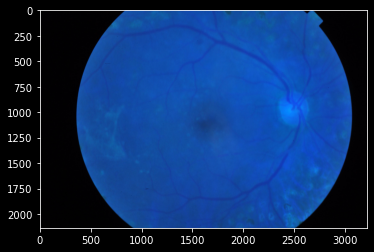

In [23]:
img = cv2.imread(os.path.join(dir_src, fnames[1]))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

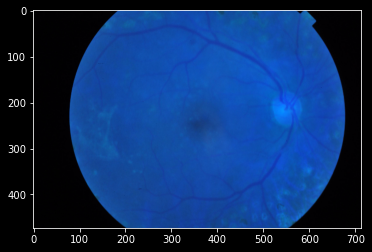

In [24]:
img = _scale_radius_size(img, 300)
plt.imshow(img)

In [25]:
img = circle_crop(img, sigmaX=10)
cv2.imwrite("tes.jpeg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 72])

True

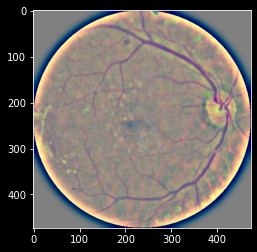

In [26]:
img = cv2.imread("tes.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Enhanced Green

- https://docs.opencv.org/3.4.2/d5/dc4/tutorial_adding_images.html
- https://docs.opencv.org/3.4.2/d4/d13/tutorial_py_filtering.html
- https://stackoverflow.com/questions/4993082/how-can-i-sharpen-an-image-in-opencv

In [27]:
# enhance image
def enhanced_green(img, alpha_=4., clip_limit_=2., sigma_=10, gamma_=0.):
    # get green channel
    g_img = img[:, :, 1]

    # create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit_, tileGridSize=(8, 8))
    g_img = clahe.apply(g_img)

    # create gaussian blur image
    img_blur = cv2.GaussianBlur(g_img, (0, 0), sigma_)

    # combine two image, original image + gaussian blur image
    beta_ = 1 - alpha_
    img_enhance = cv2.addWeighted(g_img, alpha_, img_blur, beta_, gamma_)

    return img_enhance

In [28]:
def _mask_and_crop_to_radius_singel_channel(image, target_radius_size=300, radius_mask_ratio=0.9, crop_to_radius=False):
    """Mask and crop image to the given radius ratio."""
    mask = np.zeros(image.shape)
    center = (image.shape[1]//2, image.shape[0]//2)
    radius = int(target_radius_size * radius_mask_ratio)
    cv2.circle(mask, center=center, radius=radius,
               color=(1, 1, 1), thickness=-1)
    image = image * mask + (1 - mask) * 128
    if crop_to_radius:
        x_max = min(image.shape[1] // 2 + radius, image.shape[1])
        x_min = max(image.shape[1] // 2 - radius, 0)
        y_max = min(image.shape[0] // 2 + radius, image.shape[0])
        y_min = max(image.shape[0] // 2 - radius, 0)
        image = image[y_min:y_max, x_min:x_max]
    return image

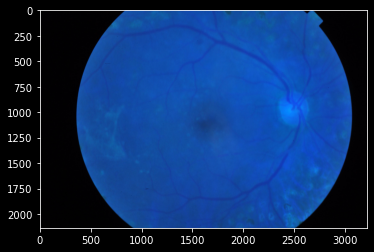

In [29]:
img = cv2.imread(os.path.join(dir_src, fnames[1]))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

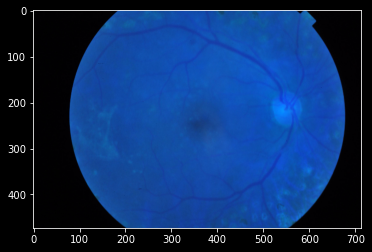

In [30]:
img = _scale_radius_size(img, 300)
plt.imshow(img)

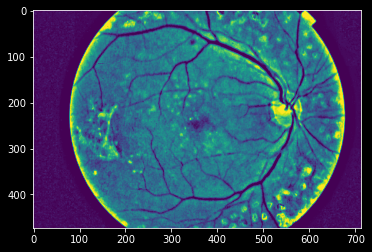

In [31]:
img = enhanced_green(img)
plt.imshow(img)

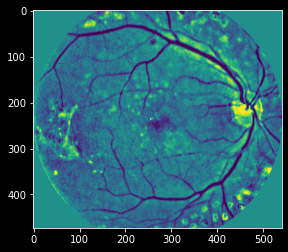

In [32]:
img = _mask_and_crop_to_radius_singel_channel(img, 300, 0.9, True)
plt.imshow(img)

In [33]:
cv2.imwrite("tes.jpeg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 72])

True

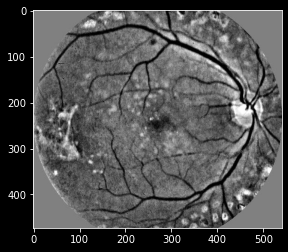

In [34]:
img = cv2.imread("tes.jpeg")
plt.imshow(img)

# Apply our code to all dataset

We will create another copy with preprocessing applied

In [35]:
# Preprocess training images.
# Scale 300 seems to be sufficient; 500 and 1000 may be overkill

scale = 300
counter = 0
list_error = list()

for f in fnames:
    counter += 1
    if counter % 250 == 0:
        print("processed images: ", counter)

    try:
        # rescale image
        img = cv2.imread(os.path.join(dir_src, f))
        img_rescaled = _scale_radius_size(img, scale)
        cv2.imwrite(os.path.join(dir_dst_rescaled, f), img_rescaled)

        # crop image using nakhon crop, we want to maintain the retinal image, not trim the border
        img_crop = crop_image_from_gray(img_rescaled)
        cv2.imwrite(os.path.join(dir_dst_crop, f), img_crop)

        # btgraham preprocessing
        img_btgraham = _subtract_local_average(img_rescaled, scale)
        img_btgraham = _mask_and_crop_to_radius(img_btgraham, scale, 0.9, True)
        cv2.imwrite(os.path.join(dir_dst_btgraham, f), img_btgraham)

        # nakhon preprocessing
        img_nakhon = circle_crop(img_rescaled)
        cv2.imwrite(os.path.join(dir_dst_nakhon, f), img_nakhon)

        # enhanced green using btgraham crop
        img_green = enhanced_green(img_rescaled)
        img_green = _mask_and_crop_to_radius_singel_channel(
            img_green, scale, 0.9, True)
        cv2.imwrite(os.path.join(dir_dst_enhanced_green, f), img_green)

        # enhanced green using nakhon crop
        img_green = enhanced_green(img_crop)
        cv2.imwrite(os.path.join(
            dir_dst_enhanced_green_crop_nakhon, f), np.dstack((img_green, img_green, img_green)))

    except:
        list_error.append(f)

processed images:  250
processed images:  500
processed images:  750
processed images:  1000
processed images:  1250
processed images:  1500
processed images:  1750
processed images:  2000
processed images:  2250
processed images:  2500
processed images:  2750
processed images:  3000
processed images:  3250
processed images:  3500


In [36]:
list_error

[]